# plot stratification index from world ocean atlas

In [1]:
%matplotlib inline
from config_calc import *

import matplotlib
import matplotlib.pyplot as plt
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'

import cmocean
import plot_tools

### read WOA data

In [2]:
woapth = '/glade/p/ncgd0033/obs/woa2013v2/1x1d'

woa_info = {
    'O2': {'varname': 'o_an', 'file' : os.path.join(woapth,'woa13_all_o00_01.nc')},   
    'O2sat': {'varname': 'O_an', 'file': os.path.join(woapth,'woa13_all_O00_01.nc')},
    'AOU': {'varname': 'A_an', 'file' : os.path.join(woapth,'woa13_all_A00_01.nc')},    
    'T' : {'varname': 't_an', 'file': os.path.join(woapth,'woa13_decav_t01_01v2.nc')},
    'S' : {'varname': 's_an', 'file': os.path.join(woapth,'woa13_decav_s01_01v2.nc')}}

woa = {}
for v,info in woa_info.items():   
    varname = info['varname']
    file_in = info['file']
    woai = xr.open_dataset(file_in,decode_times=False)
    woai = woai.drop([k for k in woai if k not in [varname,'lat','lon','depth']])
    woai = woai.rename({varname:v})
    if woa:
        woa = xr.merge((woa,woai))
    else:
        woa = woai
         
ni = len(woa.lon)
nj = len(woa.lat)

mlperl_2_mmolm3 = 1.e6 / 1.e3 / 22.3916
for v in ['O2','AOU']:
    woa[v] = woa[v] * mlperl_2_mmolm3
    woa[v].attrs['units'] = 'mmol m$^{-3}$'
woa

<xarray.Dataset>
Dimensions:  (depth: 102, lat: 180, lon: 360, time: 1)
Coordinates:
  * depth    (depth) float64 0.0 5.0 10.0 15.0 20.0 25.0 30.0 35.0 40.0 45.0 ...
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 -173.5 ...
Dimensions without coordinates: time
Data variables:
    O2sat    (time, depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    AOU      (time, depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    S        (time, depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    O2       (time, depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    T        (time, depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...

### compute density

In [3]:
import seawater as sw
na = np.newaxis
pressure = sw.eos80.pres(woa.depth.values[na,:,na,na],woa.lat.values[na,na,:,na])
woa['PD'] = woa['T'].copy()
woa.PD.values = sw.eos80.pden(woa['S'].values,woa['T'].values,pressure,pr=0.)
woa

<xarray.Dataset>
Dimensions:  (depth: 102, lat: 180, lon: 360, time: 1)
Coordinates:
  * depth    (depth) float64 0.0 5.0 10.0 15.0 20.0 25.0 30.0 35.0 40.0 45.0 ...
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 -173.5 ...
Dimensions without coordinates: time
Data variables:
    O2sat    (time, depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    AOU      (time, depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    S        (time, depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    O2       (time, depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    T        (time, depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    PD       (time, depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...

### compute stratification index
Stratication index is the difference between density in 100-200m range and 0-5m range

In [4]:
u = woa.sel(depth=slice(0,50)).mean(dim='depth').isel(time=0)
l = woa.sel(depth=slice(100,200)).mean(dim='depth').isel(time=0)
uld = l - u
uld

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 -173.5 ...
Data variables:
    O2sat    (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    AOU      (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    S        (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    O2       (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    T        (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    PD       (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan ...

[0.0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0]


/glade/p/work/mclong/miniconda2/lib/python2.7/site-packages/matplotlib/contour.py:370: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


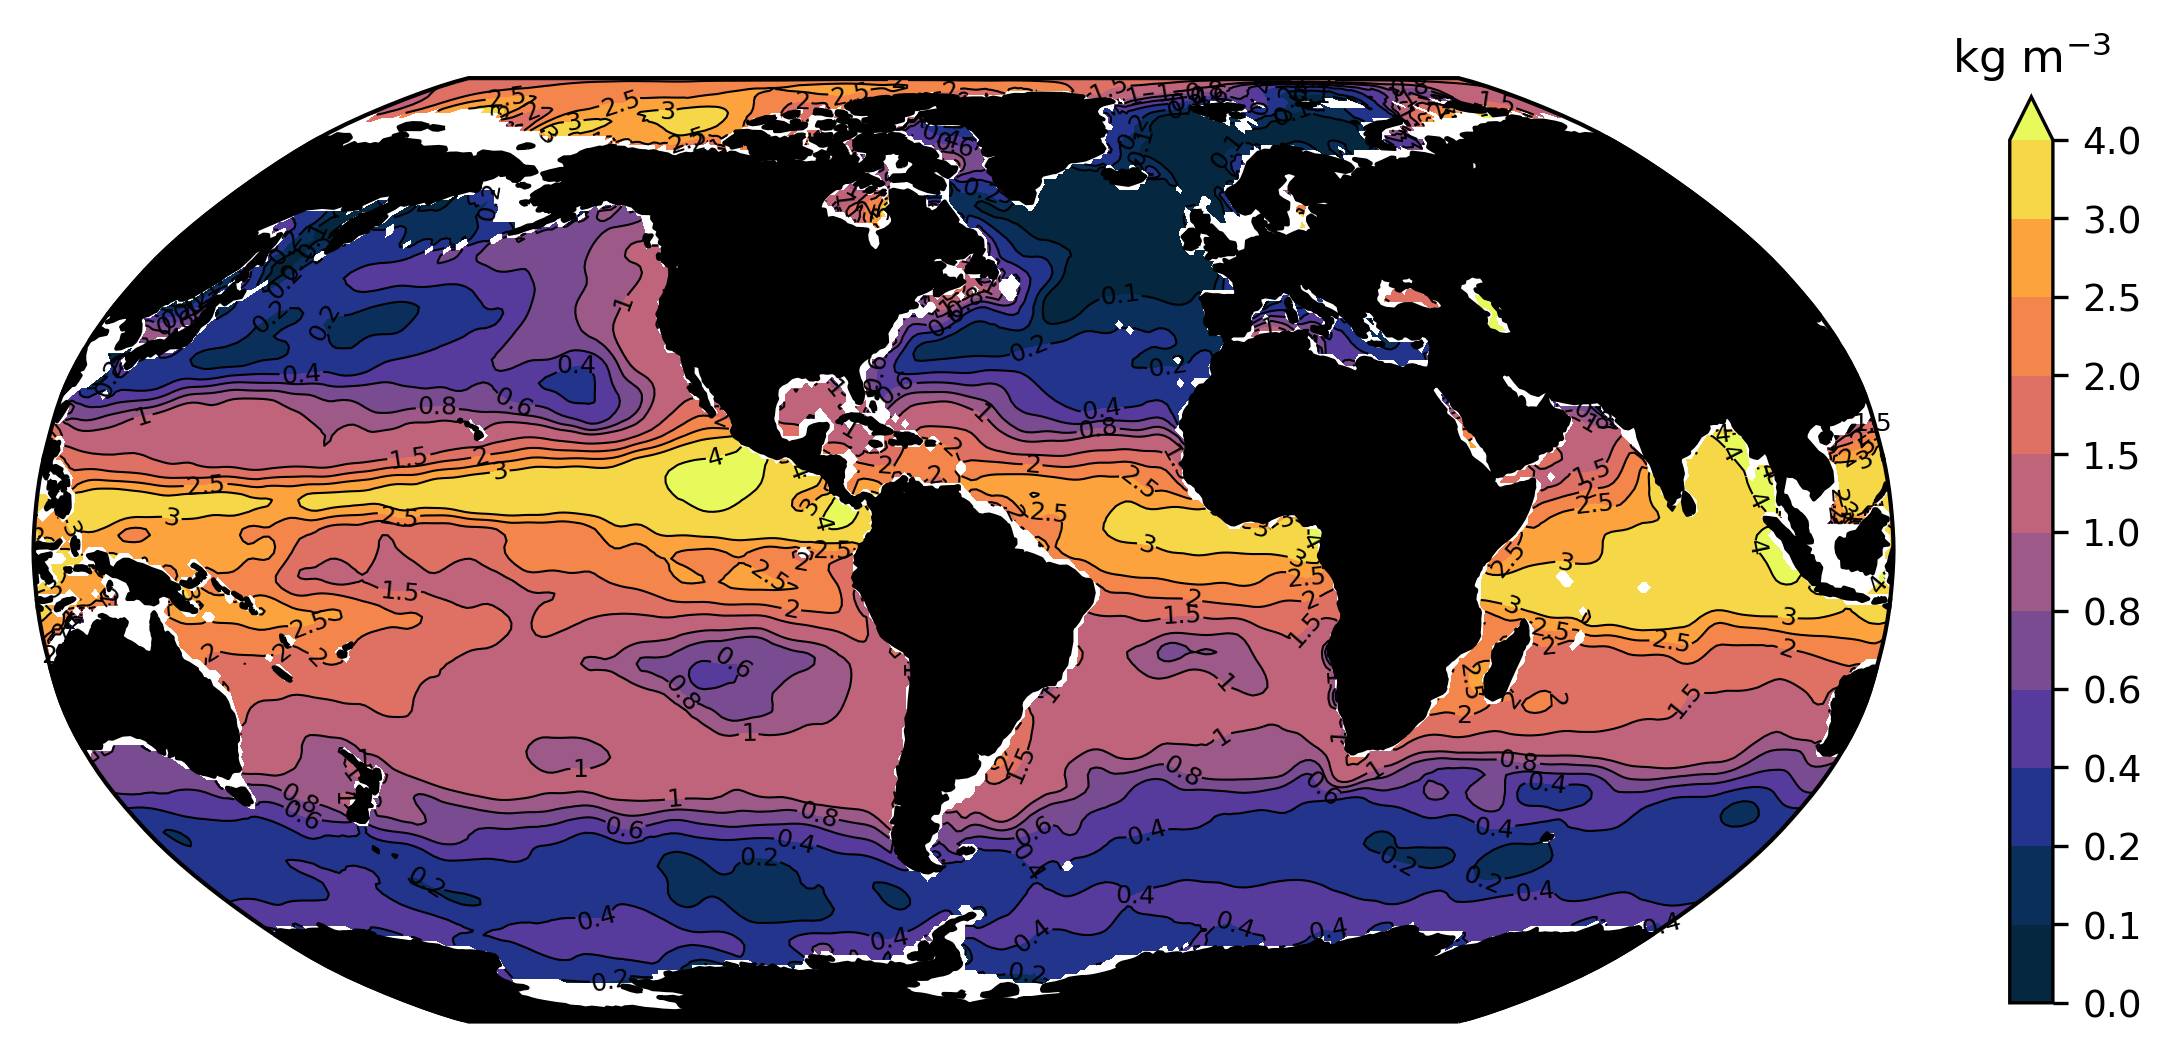

In [5]:
plot_name = os.path.join(diro['fig'],'woa-stratification-map.pdf')

cmap = cmocean.cm.thermal #'Blues_r'
units = 'kg m$^{-3}$'
levels = [0.,0.1,0.2,0.4,0.6,0.8,1.,1.5,2.,2.5,3.,4.]
print levels

lat = uld.lat.values
lon = uld.lon.values
z = uld.PD.values

lon = np.where(lon<0.,lon+360.,lon)
I = np.argsort(lon)
lon = lon[I]
z = z[:,I]
z,lon = add_cyclic_point(z,coord=lon)

fig=plt.figure(figsize=(10, 8),dpi=300)
gs = gridspec.GridSpec(1,1)

norm = plot_tools.MidPointNorm(midpoint=1.0)
contour_specs = {'levels':levels,'cmap':cmap,'extend':'max','norm':norm}
obj = plot_tools.canvas_map_contour_overlay(lon,lat,z,
                                            contour_specs,
                                            units = units,
                                            fig=fig,
                                            gridspec=gs,
                                            row=0,col=0)
plt.savefig(plot_name,bbox_inches='tight')